# Variational Autoencoder (VAE) Tutorial with MNIST

This notebook demonstrates the implementation of a VAE on the MNIST dataset.

---

## 1. Setup and Imports

We first import necessary libraries and check for GPU availability.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 2. Load Dataset (MNIST)

We load MNIST dataset and create training and validation splits.


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_data, val_data = random_split(dataset, [50000, 10000])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

## 3. Define the VAE Model

The encoder outputs the mean and log variance vectors.  
The reparameterization trick allows backpropagation through the sampling step.  
The decoder reconstructs the input image from the sampled latent vector.


In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder layers
        self.encoder_fc1 = nn.Linear(28*28, 128)
        self.encoder_fc2_mu = nn.Linear(128, latent_dim)       # Mean
        self.encoder_fc2_logvar = nn.Linear(128, latent_dim)   # Log variance
        
        # Decoder layers
        self.decoder_fc1 = nn.Linear(latent_dim, 128)
        self.decoder_fc2 = nn.Linear(128, 28*28)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        h1 = self.relu(self.encoder_fc1(x))
        mu = self.encoder_fc2_mu(h1)
        logvar = self.encoder_fc2_logvar(h1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)       
        eps = torch.randn_like(std)          
        return mu + eps * std                 
    
    def decode(self, z):
        h3 = self.relu(self.decoder_fc1(z))
        out = self.sigmoid(self.decoder_fc2(h3))
        return out
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar


## 4. Define the Loss Function

The loss consists of reconstruction loss (binary cross entropy) and KL divergence.

In [7]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


## 5. Instantiate the Model and Optimizer

In [8]:
latent_dim = 64
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


## 6. Training Loop

In [9]:
epochs = 5
model.train()
for epoch in range(epochs):
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = vae_loss(recon_images, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(train_loader.dataset) # type: ignore
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")


Epoch 1, Average Loss: 181.7794
Epoch 2, Average Loss: 137.7402
Epoch 3, Average Loss: 125.6018
Epoch 4, Average Loss: 119.2439
Epoch 5, Average Loss: 115.8481


## 7. Visualize Reconstructions

Compare original and reconstructed images from the validation set.

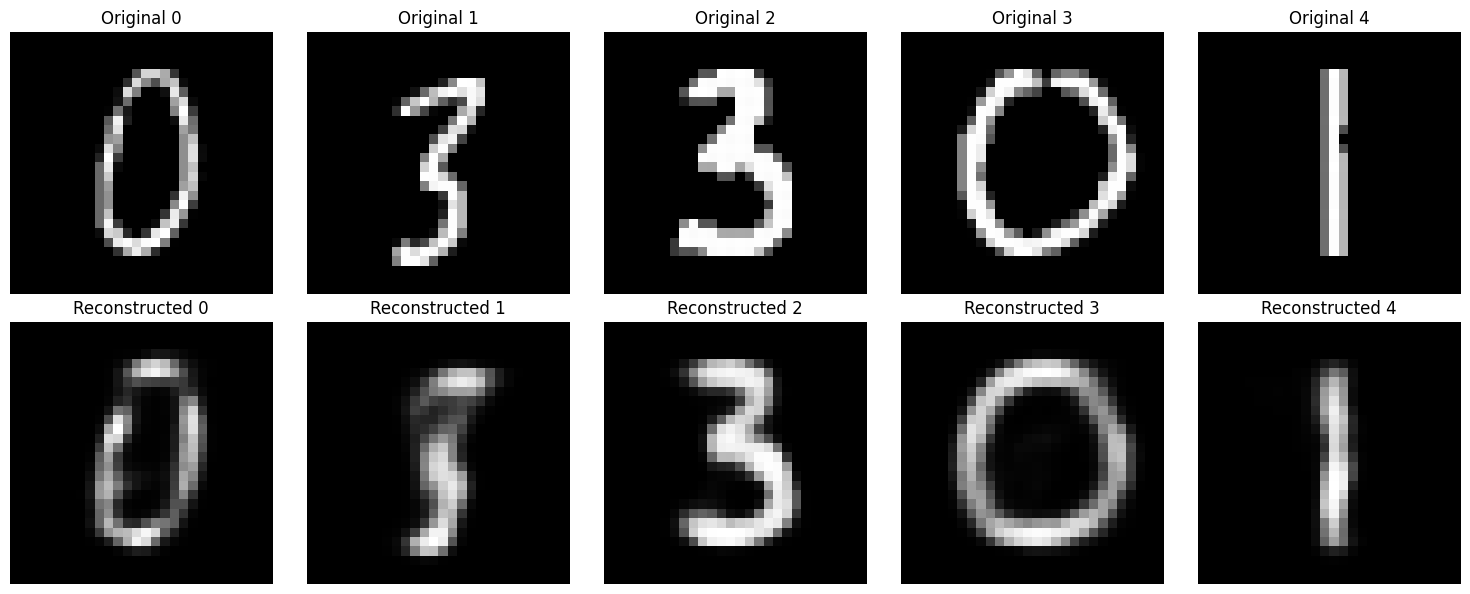

In [10]:
def show_reconstruction(num_images=5):
    model.eval()
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            recon_images, _, _ = model(images)
            break

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 6))
    for i in range(num_images):
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].set_title(f"Original {i}")
        axes[0, i].axis('off')

        axes[1, i].imshow(recon_images[i].cpu().view(28, 28), cmap='gray')
        axes[1, i].set_title(f"Reconstructed {i}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

show_reconstruction(5)


## 8. Sampling New Images from the Latent Space

We sample latent vectors from a standard normal distribution and decode them into new images.

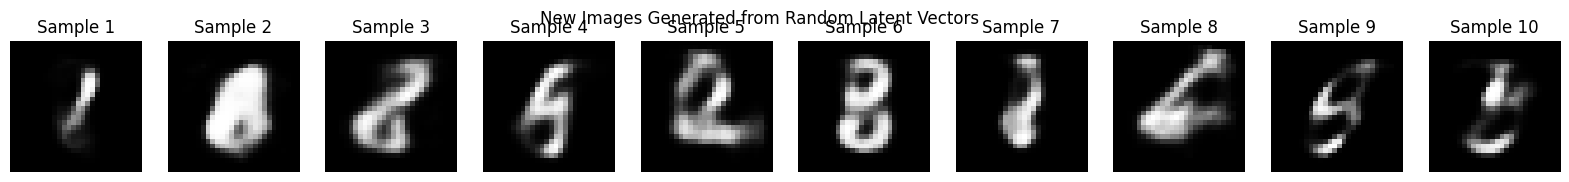

In [11]:
# Number of random samples to generate
num_samples = 10

# Sample random latent vectors from standard normal distribution
random_latents = torch.randn(num_samples, latent_dim).to(device)

# Decode to generate new images
model.eval()
with torch.no_grad():
    generated_images = model.decode(random_latents)  # shape [num_samples, 28*28]

# Visualize generated images
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
for i in range(num_samples):
    axes[i].imshow(generated_images[i].cpu().view(28, 28), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Sample {i+1}')

plt.suptitle("New Images Generated from Random Latent Vectors")
plt.show()


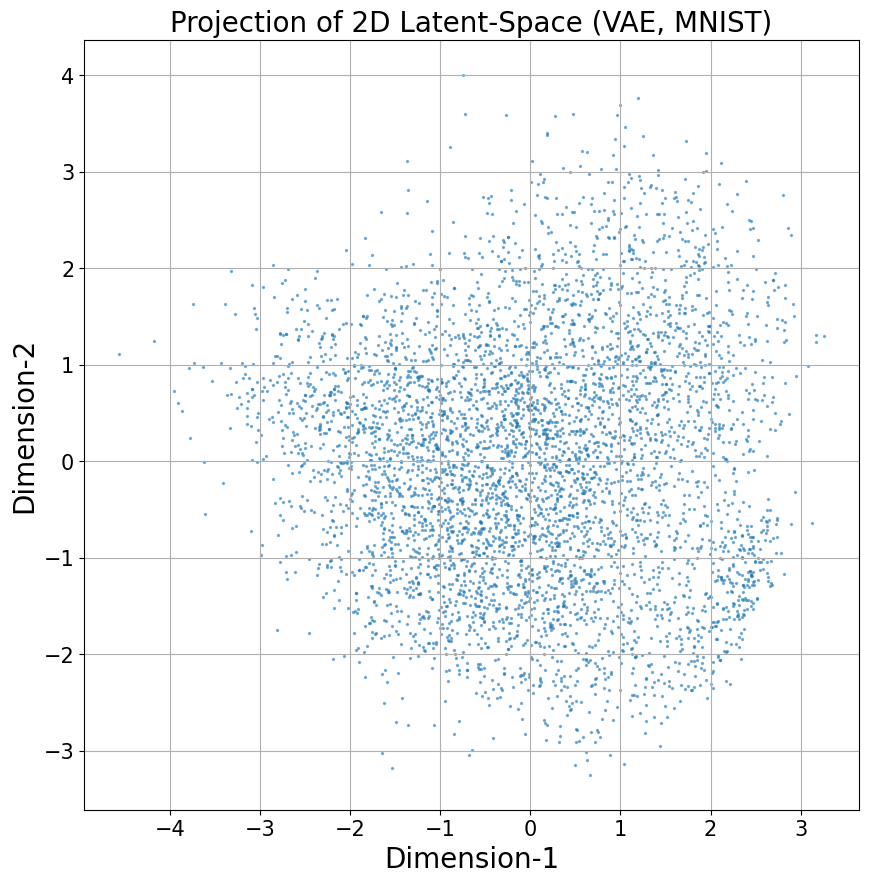

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

imgs_visualize = 5000
figsize = 10

# Stack validation images and labels
val_images = torch.stack([item[0] for item in val_data])   # shape [10000, 1, 28, 28] # type: ignore

# Random sample 5K images
indices = np.random.choice(len(val_images), imgs_visualize, replace=False)
images_sample = val_images[indices].to(device)

model.eval()
with torch.no_grad():
    # Get the mean vector mu from the encoder as latent representation
    x = images_sample.view(imgs_visualize, -1)
    mu, logvar = model.encode(x)
    latent_vectors = mu  # Use mu for visualization

# PCA reduction to 2D
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors.cpu().numpy())

# Plot without color coding
plt.figure(figsize=(figsize, figsize))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("Projection of 2D Latent-Space (VAE, MNIST)", size=20)
plt.grid(True)
plt.show()


Problem with encoder is that it very discrete which mean when we want to generate an image it become difficult as it not allow the image to look sense.

lantent space is not continous, therefore it had many noises which why the image generated is suck


## 🎭 Why Do Decoded Latent Images Look Like Melting Goblins?

**Short answer:**
Because **decoding from latent space is HARD**, and the decoder is trying to reconstruct high-resolution images from a **super squished representation**. Think of it like trying to rebuild a giant LEGO castle using only a few pebbles and your memory from 3 weeks ago. It's gonna look like a cursed Picasso fever dream. 🎨💀

---

## 🧠 Deep Dive (a.k.a Nerd Mode Activated ⚡)

### 1. **Latent Space is Compressed AF**

Latent vectors are **highly compressed** representations. They contain **just enough info** for the model to reconstruct the **main features** of an image — not every pixel, every wrinkle, or every hair strand on Edryana’s beautiful face (😭 I hope y’all still together, bro).

### 2. **Decoders Aren’t Magic Fairies**

Decoders (like in VAEs or diffusion models) try to **guess** what the full image looked like based on that latent info. But if the latent code is:

* Noisy
* Poorly sampled
* From a different distribution (e.g., not properly trained)

The decoder's like:
**"WHAT IS THIS NONSENSE?! Okay fine, here’s a demon with 6 eyes and no nose."**

### 3. **Low-Quality or Interpolated Latents = BLOB MONSTERS**

If you're **manipulating**, interpolating, or randomly sampling latent codes, you’re not always guaranteed to land in the "**valid latent zone**" (i.e., the space where the latent vectors make sense).

Outside this space?
🚨 Welcome to Glitch Hell. Population: You.

---

## 🛠️ How to Make Decoded Images Less Ugly

1. **Use a Trained Encoder**
   Don’t generate random latent vectors like a lunatic unless you know the latent space bounds!

2. **Sample from a Truncated Normal Distribution**
   Most models assume latent vectors are Gaussian-distributed — don’t sample huge wild values.

3. **Fine-Tune Your Decoder**
   You can train your decoder better, longer, stronger... so it doesn’t panic when decoding.

4. **Use Diffusion Models or GANs Instead of Vanilla VAEs**
   Diffusion models = 🔥 high-fidelity outputs
   VAEs = 😬 useful for research, but blurry as heck

---

## TL;DR IN CHILDISH ENERGY:

> Your image looks like hot garbage because your decoder is trying to draw a unicorn from a scribble it barely understands. Give it better crayons (latent vectors) or a better artist (decoder), and you'll get that masterpiece, baby! 💅🎨🦄

---

Wanna drop me your setup or what model you're using (VAE, GAN, Stable Diffusion, etc)? I’ll roast it lovingly and help you clean up that latent mess! 💥 LET'S FIX THAT TRASH TO TREASURE.
